# Librerias, semilla y funciones 

In [1]:
############### B√°sicas ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')

############### sklearn ###############

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


############### Clasifiers ###############

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


############### Tratamiento ###############

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

############### M√©tricas ####################

from sklearn.metrics import accuracy_score, balanced_accuracy_score,average_precision_score, precision_recall_curve, recall_score, precision_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc


import scikitplot as skplt
import statsmodels.api as sm


############### Configuraci√≥n ###############

os.chdir('/Users/josetunon/Desktop/ciencia_de_datos/aprendizaje_automatico/practica1_EDA/src')
import funciones as f
os.chdir('/Users/josetunon/Desktop/ciencia_de_datos/aprendizaje_automatico/practica1_EDA/notebooks')

seed=123
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



In [2]:
df_train = pd.read_csv('../data/processed_data/df_train_scaled.csv')
df_test = pd.read_csv('../data/processed_data/df_test_scaled.csv')

# Separar las caracter√≠sticas y la variable objetivo
x_test = df_test.iloc[:, :-1]  # Todas las columnas excepto la √∫ltima
y_test = df_test.iloc[:, -1]    # √öltima columna (variable objetivo)

# Dividir el conjunto de entrenamiento en entrenamiento y validaci√≥n
x_train, x_val, y_train, y_val = train_test_split(df_train.drop('TARGET', axis=1), df_train['TARGET'], 
                                                  test_size=0.2, random_state=seed  # 20% para validaci√≥n
)

# 1. - Primera comparaci√≥n de modelos (sin tratar desbalanceos)

In [3]:
# Lista de clasificadores 
classifiers = [
    DummyClassifier(strategy='most_frequent', random_state=seed),  # Clasificador simple
    LogisticRegression(random_state=seed, max_iter=1000),          # Asegurar convergencia
    GaussianNB(),                                                  # Determinista, no necesita random_state
    DecisionTreeClassifier(random_state=seed),                     # √Årbol de decisi√≥n
    RandomForestClassifier(random_state=seed),                     # Random Forest
    XGBClassifier(random_state=seed, use_label_encoder=False),     # XGBoost
    LGBMClassifier(random_state=seed, force_row_wise=True)                              # LightGBM
]


In [5]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(x_train, y_train)   
    y_pred = pipe.predict(x_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(x_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier(random_state=123, strategy='most_frequent')
model score: 0.919

    accuracy = 0.9193935205885939
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45236     0]
 [ 3966     0]]
    
LogisticRegression(max_iter=1000, random_state=123)
model score: 0.920

    accuracy = 0.9195764399821146
    precision = 0.56
    recall = 0.01059001512859304
    f1_score = 0.02078693392724573
    confusion matrix:
    [[45203    33]
 [ 3924    42]]
    
GaussianNB()
model score: 0.758

    accuracy = 0.7578147229787408
    precision = 0.16158692320790055
    recall = 0.4785678265254665
    f1_score = 0.24159877800407328
    confusion matrix:
    [[35388  9848]
 [ 2068  1898]]
    
DecisionTreeClassifier(random_state=123)
model score: 0.851

    accuracy = 0.8505142067395635
    precision = 0.13985122210414452
    recall = 0.16591023701462432
    f1_score = 0.15177026871179794
    confusion matrix:
    [[41189  4047]
 [ 3308   658]]
    
RandomForestClassi

# 1.1. - GaussianNB - Naive Bayes

A priori de entre estos modelos vanilla el que mejor funciona es el Gaussiano. De base ya nos est√° dando un 50% de recall sacrificando un poco de precisi√≥n. El score que recibe es el m√°s bajo de los modelos pero es el que mejor predice la clase minoritaria, que es lo que m√°s le interesa a un banco, ser capaz de predecir que clientes no van a poder pagar, por ello vamos a seguir con el.



In [6]:
# Definir modelo
model = GaussianNB()

# Definir rango de b√∫squeda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validaci√≥n cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperpar√°metros
grid_search.fit(x_train, y_train)

# Obtener el mejor modelo
gaussian_unbalanced_model = grid_search.best_estimator_

# Predecir en el conjunto de validaci√≥n
y_pred = gaussian_unbalanced_model.predict(x_val)

# Calcular m√©tricas adicionales
recall = recall_score(y_val, y_pred)  
f2_score = fbeta_score(y_val, y_pred, beta=2)  
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperpar√°metros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validaci√≥n: {accuracy:.4f}")
print(f"Recall en el conjunto de validaci√≥n: {recall:.4f}")
print(f"F2-Score en el conjunto de validaci√≥n: {f2_score:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperpar√°metros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.825940159465814
Accuracy en el conjunto de validaci√≥n: 0.7875
Recall en el conjunto de validaci√≥n: 0.4334
F2-Score en el conjunto de validaci√≥n: 0.3332


Hemos mejorado la precisi√≥n pero a cambio de recall. Hemos conseguido unos resultados bastante normalitos a√∫n con el fine-tuning. El problema de este tipo de modelo es que al contar con muy pocos hiperpar√°metros, no va a mejorar demasiado seg√∫n se combinen ya que hay pocas opciones. De todas formas voy a analizar las ventajas y dsventajas de este modelo buscando alguna forma de poder mejorar el resultado.

Ventajas: 
- Eficiencia computacional: Es extremadamente r√°pido de entrenar y predecir porque solo requiere el c√°lculo de estad√≠sticas b√°sicas.
- Escalabilidad: Escala bien con datos grandes.
- Interpretabilidad: F√°cil de entender y explicar.
- Requiere pocos datos: Funciona bien con datasets peque√±os o moderados.

Desvenatajas: 
- Se basa en que las variables son independientes --> revisar interdependencia de las variales 
- Requiere una distribuci√≥n Gaussiana 
- Sensibilidad a los valores at√≠picos 

Viendo estas limitaciones que tiene, es conveniente revisar si nuestros datos de adaptan bien a ellas.Estas 2 √∫ltimas limitaciones ya se solucionaron con el procesos de estandarizaci√≥n que realizamos en '03_Feature_Processing.ipynb', por lo que no deber√≠a suponer un problema. En cuanto a la independencia de las varaibles hab√≠a algunas que estaban muy correlacionadas cuando lo estudiamos en el notebook 2.

Por esto vamos revisar correlaciones e independencias y valorar posteriormente la eliminaci√≥n de algunas variables y ver si as√≠ el resultdao mejora.


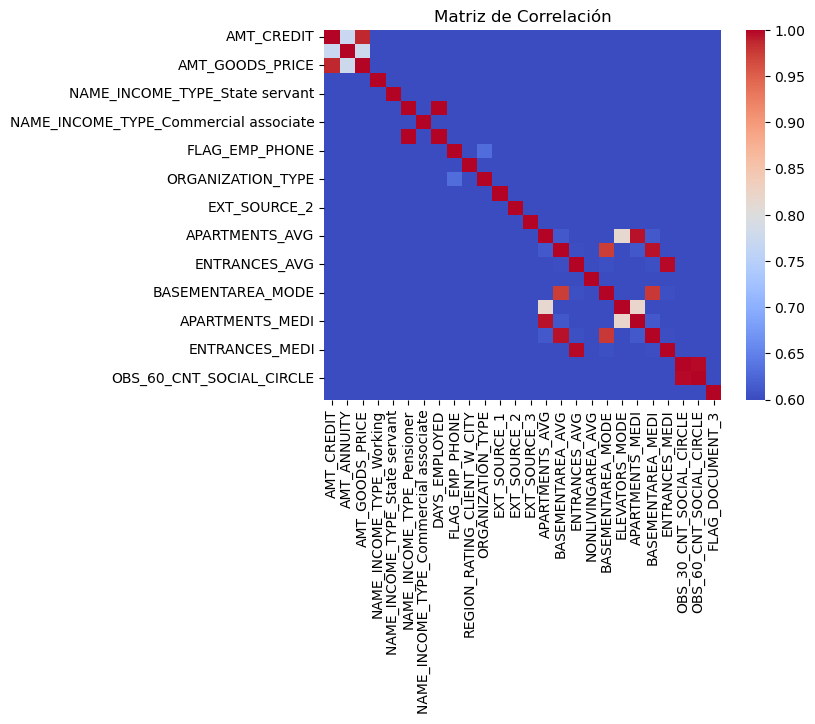

In [7]:
correlation_matrix = x_train.corr()
sns.heatmap(correlation_matrix, annot=False, vmin=0.6, cmap="coolwarm")
plt.title("Matriz de Correlaci√≥n")
plt.show()

In [8]:
new_corr = correlation_matrix.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.5]

level_0                     level_1  \
215                         FLAG_EMP_PHONE               DAYS_EMPLOYED   
213                         FLAG_EMP_PHONE  NAME_INCOME_TYPE_Pensioner   
187                          DAYS_EMPLOYED  NAME_INCOME_TYPE_Pensioner   
647               OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE   
588                         ENTRANCES_MEDI               ENTRANCES_AVG   
534                        APARTMENTS_MEDI              APARTMENTS_AVG   
561                      BASEMENTAREA_MEDI            BASEMENTAREA_AVG   
52                         AMT_GOODS_PRICE                  AMT_CREDIT   
564                      BASEMENTAREA_MEDI           BASEMENTAREA_MODE   
483                      BASEMENTAREA_MODE            BASEMENTAREA_AVG   
539                        APARTMENTS_MEDI              ELEVATORS_MODE   
508                         ELEVATORS_MODE              APARTMENTS_AVG   
53                         AMT_GOODS_PRICE                 AMT_ANNUITY   
26                             AMT_ANNUITY                  AMT_CREDIT   
268                      ORGANIZATION_TYPE              FLAG_EMP_PHONE   
265                      ORGANIZATION_TYPE  NAME_INCOME_TYPE_Pensioner   
267                      ORGANIZATION_TYPE               DAYS_EMPLOYED   
566                      BASEMENTAREA_MEDI             APARTMENTS_MEDI   
404                       BASEMENTAREA_AVG              APARTMENTS_AVG   
560                      BASEMENTAREA_MEDI              APARTMENTS_AVG   
535                        APARTMENTS_MEDI            BASEMENTAREA_AVG   
484                      BASEMENTAREA_MODE               ENTRANCES_AVG   
562                      BASEMENTAREA_MEDI               ENTRANCES_AVG   
590                         ENTRANCES_MEDI           BASEMENTAREA_MODE   
593                         ENTRANCES_MEDI           BASEMENTAREA_MEDI   
431                          ENTRANCES_AVG            BASEMENTAREA_AVG   
587                         ENTRANCES_MEDI            BASEMENTAREA_AVG   
538                        APARTMENTS_MEDI           BASEMENTAREA_MODE   
482                      BASEMENTAREA_MODE              APARTMENTS_AVG   
430                          ENTRANCES_AVG              APARTMENTS_AVG   
592                         ENTRANCES_MEDI             APARTMENTS_MEDI   
536                        APARTMENTS_MEDI               ENTRANCES_AVG   
586                         ENTRANCES_MEDI              APARTMENTS_AVG   
159  NAME_INCOME_TYPE_Commercial associate    NAME_INCOME_TYPE_Working   

     correlation  
215     0.999783  
213     0.999467  
187     0.999454  
647     0.998367  
588     0.996907  
534     0.995091  
561     0.994510  
52      0.986529  
564     0.977954  
483     0.973641  
539     0.818810  
508     0.814955  
53      0.775277  
26      0.770737  
268     0.629820  
265     0.629658  
267     0.627337  
566     0.612370  
404     0.612077  
560     0.611551  
535     0.610465  
484     0.603991  
562     0.603459  
590     0.603323  
593     0.602515  
431     0.601782  
587     0.598391  
538     0.597343  
482     0.595679  
430     0.592675  
592     0.592515  
536     0.592491  
586     0.589540  
159     0.569509

Como se puede ver hay unas cuantas variables que est√°n relacionadas casi al 100%. Voy a ir seleccionando en cada pareja de variables la que voy a eliminar en funci√≥n de: 
- Cual es m√°s dif√≠cil de interpretar --> 'FLAG_EMP_PHONE'
- Que informaci√≥n es menos √∫til, por ejemplo he decidod eliminar lo casos de '_MODE'

Despu√©s de realizar esto, voy a volver a tirar el modelo y evaluar√© si existe alg√∫n tipo de mejora

In [9]:
lista_eliminar = ['FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ENTRANCES_MEDI', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                  'AMT_GOODS_PRICE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MODE']

# Eliminar columnas del conjunto de entrenamiento y prueba
x_train_reduced = x_train.drop(columns=lista_eliminar)
x_test_reduced = x_test.drop(columns=lista_eliminar)
x_val_reduced = x_val.drop(columns=lista_eliminar)

assert list(x_train_reduced.columns) == list(x_test_reduced.columns), "Los conjuntos no tienen las mismas columnas."

In [10]:
# Definir modelo
model = GaussianNB()

# Definir rango de b√∫squeda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5,  # Validaci√≥n cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperpar√°metros
grid_search.fit(x_train_reduced, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predecir en el conjunto de validaci√≥n
y_pred = best_model.predict(x_val_reduced)

# Calcular m√©tricas adicionales
recall = recall_score(y_val, y_pred,) 
f2_score = fbeta_score(y_val, y_pred, beta=2) 
accuracy = accuracy_score(y_val, y_pred)

# Resultados
print("Mejores hiperpar√°metros:", grid_search.best_params_)
print("Mejor F1-Score (GridSearchCV):", grid_search.best_score_)
print(f"Accuracy en el conjunto de validaci√≥n: {accuracy:.4f}")
print(f"Recall en el conjunto de validaci√≥n: {recall:.4f}")
print(f"F2-Score en el conjunto de validaci√≥n: {f2_score:.4f}")

# Matriz de confusi√≥n
print("\nMatriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperpar√°metros: {'var_smoothing': 0.1}
Mejor F1-Score (GridSearchCV): 0.8812199580170471
Accuracy en el conjunto de validaci√≥n: 0.8824
Recall en el conjunto de validaci√≥n: 0.2148
F2-Score en el conjunto de validaci√≥n: 0.2197

Matriz de confusi√≥n:
[[42562  2674]
 [ 3114   852]]


Los resultados conseguidos tras eliminar las columnas dependientes han empeorado claramente. La precisi√≥n ha aumentado en 7 puntos pero el recall, la medida objetivo, se ha desplomado. Voy a dejar este modelo aqu√≠ porque no veo forma de poder mejorarlo. 

Es un modelo simple que de primeras ha dado unos resultados que parecian buenos. El problema que presenta es precisamente eso, su simpleza, al no tener par√°metros que ayuden a que se adapte a cada caso hace que la cantidad de mejora sea muy baja.

En base a esto y analizando un poco cada modelo, el que tratar√≠a de optimizar ahora es el XGBoost. Pero viendo los malos resultados a nivel general, voy a considerar hacer previamente un balanceo.

# 2. - Oversampling y undersampling

Me he dado cuenta de que, en este caso, y probablemente en muchos otros, es imprescindible tratar el desbalanceo de las clases. Los modelos que se generan con datos tan desbalanceados resultan pr√°cticamente in√∫tiles, ya que tienden a sobreajustarse incluso con peque√±os ajustes en los hiperpar√°metros. Esto no solo afecta el rendimiento del modelo, sino que limita significativamente su capacidad de generalizaci√≥n.

Por tanto, trabajar directamente con datos desbalanceados como los actuales no es una opci√≥n viable. Para abordar este problema, voy a aplicar t√©cnicas de undersampling y oversampling, que son los enfoques m√°s utilizados en este tipo de situaciones. Considero que, dado el grado de desbalanceo en los datos, ser√° necesario utilizar una combinaci√≥n de ambos m√©todos para lograr un balance adecuado entre las clases.

El objetivo de este enfoque es reducir el riesgo de sobreajuste que surge al intentar entrenar modelos con datos altamente desbalanceados, mientras se mantiene suficiente informaci√≥n en el conjunto de datos para que el modelo pueda aprender patrones significativos. Por lo tanto, proceder√© a implementar estas t√©cnicas y evaluar su impacto en el rendimiento del modelo.

El desbalanceo se trata principalemente mediante t√©cnidas de oversampling y undersampling.
- Oversampling. Consiste en aumentar la cantidad de muestras de la clase minoritaria replic√°ndolas o generando nuevas muestras sint√©ticas.
    - Random Oversampling: Duplica aleatoriamente las muestras de la clase minoritaria.
    - SMOTE (Synthetic Minority Oversampling Technique): Genera muestras sint√©ticas interpolando entre instancias cercanas de la clase minoritaria.
    - ADASYN (Adaptive Synthetic Sampling): Similar a SMOTE, pero genera m√°s muestras sint√©ticas en regiones con menor densidad.

- Undersampling. Consiste en reducir el n√∫mero de muestras de la clase mayoritaria eliminando instancias de forma aleatoria o estructurada.
    - Random Undersampling: Elimina muestras aleatorias de la clase mayoritaria.
    - Tomek Links: Identifica pares de muestras de clases opuestas que est√°n muy cercanas y elimina la muestra mayoritaria.
    - NearMiss: Selecciona muestras de la clase mayoritaria que est√°n m√°s cerca de las de la clase minoritaria.

En este caso debido al desbalanceo tan grande que hay (s√≥lo un 8.07% de la clase minoritaria) voy a usar ambos m√©todos. Primero voy a generar datos sint√©ticos mediante SMOTE porque me parece que es el que mejor se puede adaptar a este caso. Ya que Randomo Oversampling a√±ade un componenente de aleatoriedad que creo que empeorar√° las predicciones del modelo y con la cantidad total de datos que tenemos, crear datos sint√©ticos no va a alterar la informaci√≥n en exceso.

Despu√©s lo que har√© ser√° aplicar un 'RandomSampler' para eliminar de forma aleatoria instancias de la clase mayoritaria. Con esto pretendo conseguir un cierto balanceo de las clases para evitar que el modelo se centre en aprender solo una de las clases.

Para llegar a esta conclusi√≥n e ido incrementando progresivamente el balanceo mientras comprobaba como mejoraban las predicciones de los modelos vanilla. Despu√©s de realizar considerables pruebas, he encontrado este punto en el que consigo mejores resultados sin incrementar en exceso del balanceo de la clase minoritaria.

In [4]:
# Configurar SMOTE
smote = SMOTE(
    sampling_strategy=0.4,  # La clase minoritaria ser√° el 50% de la mayoritaria
    k_neighbors=4,          # Usar 4 vecinos para interpolaci√≥n
    random_state=seed,        # Reproducibilidad
    n_jobs=-1               # Usar todos los n√∫cleos disponibles
)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
y_train_resampled.value_counts()/ len(y_train_resampled)


TARGET
0    0.714288
1    0.285712
Name: count, dtype: float64

In [5]:
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=seed)
x_resampled, y_resampled = undersampler.fit_resample(x_train_resampled, y_train_resampled)
values = y_resampled.value_counts()/len(y_resampled)

print(len(y_train))
print(len(y_train_resampled))
print(len(y_resampled))
print(values)

196806
253276
192970
TARGET
0    0.624999
1    0.375001
Name: count, dtype: float64


Al final he llegado a esta combinaci√≥n de resultados en la que la clase minoritaria llega a ser un 37%.5, a este punto he llegado con:
 - 56.406 observaciones creadas mediante 'SMOTE'
 - 60.290 observaciones (con y = 0) eliminadas mediante 'RandomUnderSampler'


# 3. - Evaluaci√≥n modelos (clases balanceadas)

# 3.1. - Modelos Vanilla

In [13]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(x_resampled, y_resampled)   
    y_pred = pipe.predict(x_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # (y_true, y_pred)
    c_matrix = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)


    print(classifier)
    print("model score: %.3f" % pipe.score(x_val, y_val))
    print(f"""
    accuracy = {accuracy}
    precision = {precision}
    recall = {recall}
    f1_score = {f1}
    confusion matrix:
    {c_matrix}
    """)

DummyClassifier(random_state=123, strategy='most_frequent')
model score: 0.919

    accuracy = 0.9193935205885939
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    confusion matrix:
    [[45236     0]
 [ 3966     0]]
    
LogisticRegression(max_iter=1000, random_state=123)
model score: 0.812

    accuracy = 0.8119791878378928
    precision = 0.2011760714689585
    recall = 0.4485627836611195
    f1_score = 0.2777734405496135
    confusion matrix:
    [[38172  7064]
 [ 2187  1779]]
    
GaussianNB()
model score: 0.485

    accuracy = 0.4850209341083696
    precision = 0.10509977827050998
    recall = 0.7170953101361573
    f1_score = 0.18333011023012957
    confusion matrix:
    [[21020 24216]
 [ 1122  2844]]
    
DecisionTreeClassifier(random_state=123)
model score: 0.777

    accuracy = 0.7773870980854437
    precision = 0.1190709846254498
    recall = 0.2753403933434191
    f1_score = 0.1662480018269011
    confusion matrix:
    [[37157  8079]
 [ 2874  1092]]
    
RandomFor

# 3.2. - Modelos candidatos

# 3.2.1 - Logistic Regresion

La regresi√≥n log√≠stica es un modelo de clasificaci√≥n que predice la probabilidad de que una muestra pertenezca a una clase espec√≠fica. Primero, combina las caracter√≠sticas de entrada mediante una f√≥rmula lineal: 
ùëß = ùë§^ùëá * ùëã + ùëè. Este valor se transforma en una probabilidad usando la funci√≥n sigmoide: ùúé(ùëß)= 1/ (1+ùëí^‚àíùëß), que siempre produce valores entre 0 y 1. 

El modelo clasifica la muestra seg√∫n un umbral, generalmente 0.5, asign√°ndola a la clase positiva si la probabilidad es mayor o igual a este umbral. Durante el entrenamiento, ajusta los pesos y el sesgo para minimizar el error en las predicciones, utilizando una funci√≥n de p√©rdida llamada log-loss. Este enfoque permite capturar relaciones lineales entre las caracter√≠sticas y la clase objetivo, siendo una herramienta simple, eficiente y f√°cil de interpretar.

In [ ]:
# Configurar el Pipeline
lr_pipeline = Pipeline(steps=[('classifier', LogisticRegression(random_state=seed, max_iter=1000))])

# Definir el espacio de hiperpar√°metros
param_grid = {
    'classifier__C': [0.88, 0.89, 0.9, 0.91, 0.92],         # Coeficiente de regularizaci√≥n
    'classifier__penalty': ['l1'],                          # Tipo de regularizaci√≥n
    'classifier__solver': [ 'saga'],                        # Solvers compatibles con regularizaci√≥n
    'classifier__l1_ratio': [0.23, 0.24, 0.25, 0.26, 0.27]  # Solo para 'elasticnet'
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # N√∫mero de combinaciones a probar
    cv=10,  # Validaci√≥n cruzada
    scoring=make_scorer(f1_score, average='weighted'),  # M√©trica de evaluaci√≥n
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los n√∫cleos disponibles
    verbose=1
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)
y_pred = CV.predict(x_val)

# Almacenar modelo y mejores par√°metros
logistic_model = CV.best_estimator_
best_params_lr = CV.best_params_

# Imprimir los mejores par√°metros y el mejor score
print("Mejores par√°metros:", CV.best_params_)
print("Mejor score:", CV.best_score_)

# Reporte de clasificaci√≥n
print(classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title('Normalizada')

print(disp.confusion_matrix)





Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elastic

[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elastic

[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/o

[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.92, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  war

[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min
[CV] END classifier__C=0.91, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.3min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.91, classifier__l1_ratio=0.23, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.89, classifier__l1_ratio=0.25, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min
[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.9, classifier__l1_ratio=0.24, classifier__penalty=l1, classifier__solver=saga; total time= 3.5min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.27, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 3.4min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min
[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min


/opt/miniconda3/envs/aa_p2_eda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.88, classifier__l1_ratio=0.26, classifier__penalty=l1, classifier__solver=saga; total time= 2.2min
Mejores par√°metros: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.23, 'classifier__C': 0.89}
Mejor score: 0.6873037195250237
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     45282
           1       0.20      0.46      0.28      3920

    accuracy                           0.81     49202
   macro avg       0.57      0.65      0.59     49202
weighted avg       0.89      0.81      0.84     49202



# **Reejecutar esta celda**

[[0.95808489 0.04191511]
 [0.82908163 0.17091837]]


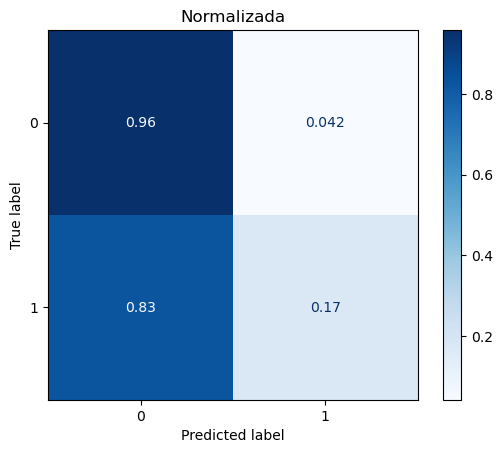

In [ ]:

best_params_rl = {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__l1_ratio': 0.23, 'classifier__C': 0.89}



# 3.2.2 - √Årbol de decisi√≥n

Un √Årbol de Decisi√≥n es un modelo de machine learning interpretable utilizado tanto para clasificaci√≥n como para regresi√≥n. Su estructura se asemeja a un √°rbol, donde cada nodo interno representa una decisi√≥n basada en una caracter√≠stica, cada rama representa un resultado posible, y cada hoja representa una predicci√≥n (una clase o un valor).

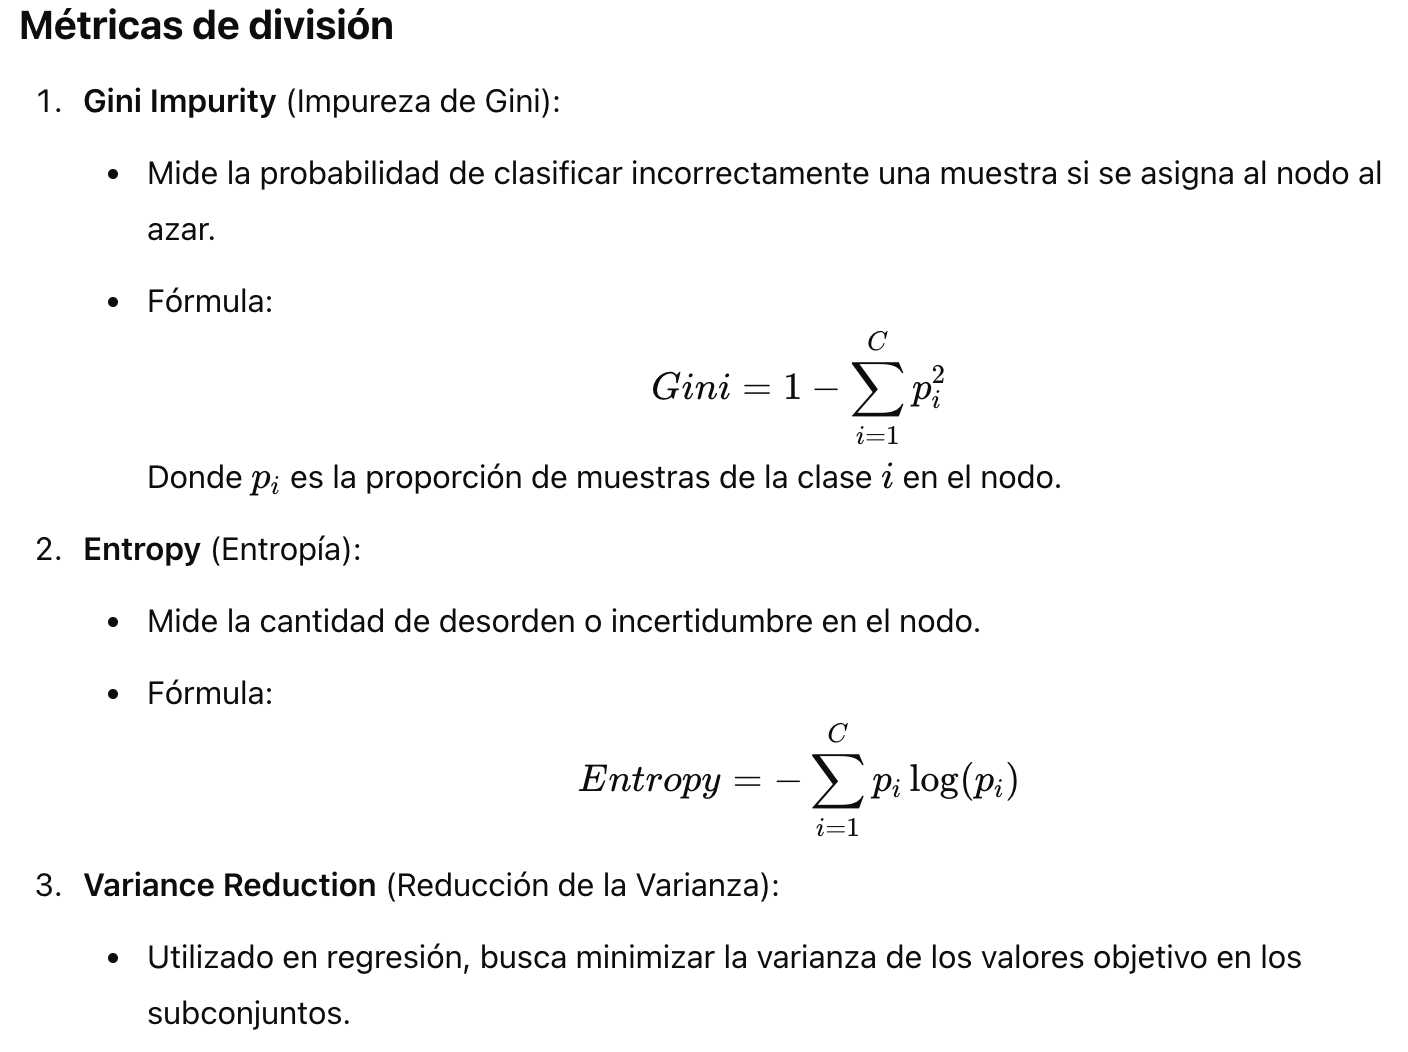

Ventajas

- Interpretabilidad: F√°cil de entender y visualizar.
- Flexible: Puede manejar datos categ√≥ricos y num√©ricos.
- No requiere normalizaci√≥n: No depende de la escala de las caracter√≠sticas.
- Captura interacciones: Puede identificar autom√°ticamente interacciones entre caracter√≠sticas.

Limitaciones
- Sobreajuste: Los √°rboles profundos tienden a memorizar los datos de entrenamiento.
    - Mitigaci√≥n: Limitar la profundidad del √°rbol o usar poda.
- Inestabilidad: Peque√±os cambios en los datos pueden generar estructuras de √°rbol diferentes.

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores par√°metros: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_leaf_nodes': None, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Mejor score (validaci√≥n cruzada): 0.5469436419354787

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     45236
           1       0.15      0.35      0.21      3966

    accuracy                           0.78     49202
   macro avg       0.54      0.59      0.54     49202
weighted avg       0.87      0.78      0.82     49202



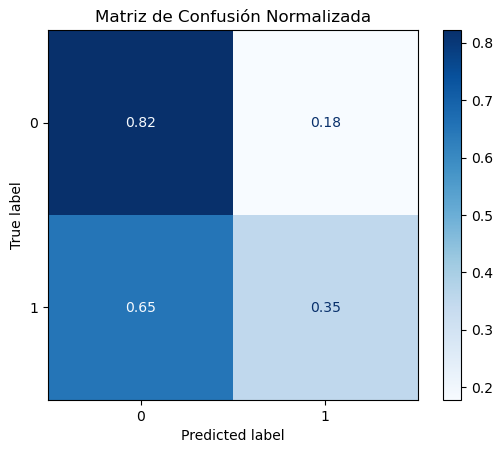


Matriz de confusi√≥n (normalizada):
[[0.82184543 0.17815457]
 [0.64977307 0.35022693]]


In [6]:
# Configurar el Pipeline
dt_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=seed))])

# Definir el espacio de hiperpar√°metros
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],         # Funci√≥n de evaluaci√≥n para los nodos
    'classifier__max_depth': [3, 5, 10, None],           # Profundidad m√°xima del √°rbol
    'classifier__min_samples_split': [2, 5, 10],         # N√∫mero m√≠nimo de muestras para dividir un nodo
    'classifier__min_samples_leaf': [1, 2, 4],           # N√∫mero m√≠nimo de muestras en una hoja
    'classifier__max_features': [None, 'sqrt', 'log2'],  # N√∫mero m√°ximo de caracter√≠sticas a considerar
    'classifier__max_leaf_nodes': [None, 10, 20, 50],    # N√∫mero m√°ximo de nodos hoja
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # N√∫mero de combinaciones a probar
    cv=10,  # Validaci√≥n cruzada
    scoring= make_scorer(f1_score), 
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los n√∫cleos disponibles
    verbose=1   # Para que nose vaya viendo cada innstacia que calcula el modelo 
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

y_pred = CV.predict(x_val)
best_dt = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

# 3.2.4. - LightGMB

LightGBM (Light Gradient Boosting Machine) es un modelo de aprendizaje autom√°tico basado en boosting que utiliza √°rboles de decisi√≥n como predictores. Funciona de manera iterativa, donde cada √°rbol trata de corregir los errores del conjunto anterior, optimizando una funci√≥n de p√©rdida.



[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 w

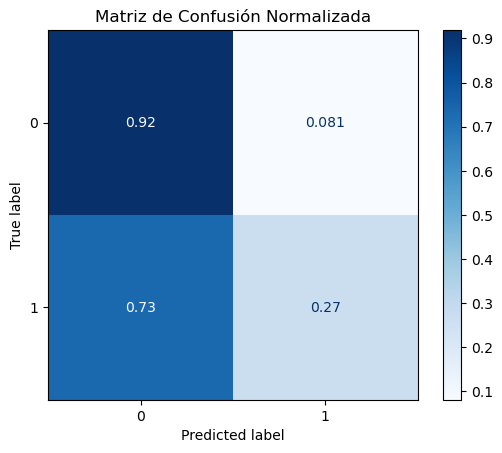


Matriz de confusi√≥n (normalizada):
[[0.91889203 0.08110797]
 [0.73474534 0.26525466]]


In [9]:
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# Configurar el Pipeline
lgbm_pipeline = Pipeline(steps=[('classifier', LGBMClassifier(random_state=seed, class_weight='balanced'))])

# Definir el espacio de hiperpar√°metros
param_grid = {
    'classifier__n_estimators': [230, 250, 270],       # N√∫mero de √°rboles
    'classifier__max_depth': [6, 7, 8],           # Profundidad m√°xima (-1 para sin l√≠mite)
    'classifier__learning_rate': [0.08, 0.09, 0.1],   # Tasa de aprendizaje
    'classifier__subsample': [0.6, 0.8, 1.0],         # Fracci√≥n de datos para cada √°rbol
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],  # Fracci√≥n de caracter√≠sticas para cada √°rbol
    'classifier__min_child_samples': [25, 30, 35],    # Muestras m√≠nimas en una hoja
    'classifier__num_leaves': [31, 34, 36],          # N√∫mero m√°ximo de hojas en un √°rbol
    'classifier__lambda_l1': [0.0, 0.05, 0.1],          # Regularizaci√≥n L1
    'classifier__lambda_l2': [0.0, 0.05, 0.1], 
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # N√∫mero de combinaciones a probar
    cv=10,  # Validaci√≥n cruzada
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los n√∫cleos disponibles
    verbose= 0 # Lo pongo as√≠ para no ensuciar el notebook final --> 0 mensajes
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

# Almacenos el modelo y los mejores par√°metros 
lghtgbm_model = CV.best_estimator_
lightgbm_best_params = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

In [ ]:
y_pred_proba = CV.predict_proba(x_val)[:, 1]
threshold = 0.35  # Prueba valores como 0.3 o 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

# 3.2.5. - GaussianNB()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores par√°metros: {'var_smoothing': 1e-12}
Mejor score (validaci√≥n cruzada): 0.5683992330414054

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.95      0.46      0.62     45236
           1       0.11      0.72      0.18      3966

    accuracy                           0.49     49202
   macro avg       0.53      0.59      0.40     49202
weighted avg       0.88      0.49      0.59     49202



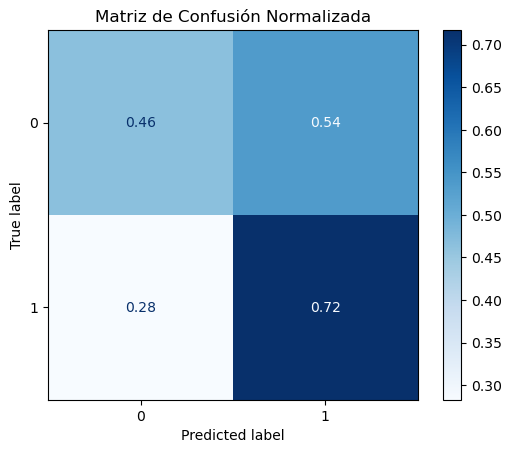


Matriz de confusi√≥n (normalizada):
[[0.46467415 0.53532585]
 [0.28290469 0.71709531]]


In [ ]:
# Definir modelo
model = GaussianNB()

# Definir rango de b√∫squeda para var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-9, 1e-6, 1e-3, 1e-1]}

# Configurar GridSearchCV
CV = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring= 'accuracy',
    cv=5,  # Validaci√≥n cruzada de 5 pliegues
    verbose=1
)

# Entrenar y buscar mejores hiperpar√°metros
CV.fit(x_resampled, y_resampled)

## Obtener el mejor modelo y predecir en el conjunto de validaci√≥n
y_pred = CV.predict(x_val)
gaussian_model = grid_search.best_estimator_

f.fast_eval(CV, x_val, y_val, y_pred)

# 3.2.3. - XGBClassifier

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mejores par√°metros: {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 4, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.9}
Mejor score (validaci√≥n cruzada): 0.7185114167085442

Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     45236
           1       0.15      0.35      0.21      3966

    accuracy                           0.78     49202
   macro avg       0.54      0.59      0.54     49202
weighted avg       0.87      0.78      0.82     49202



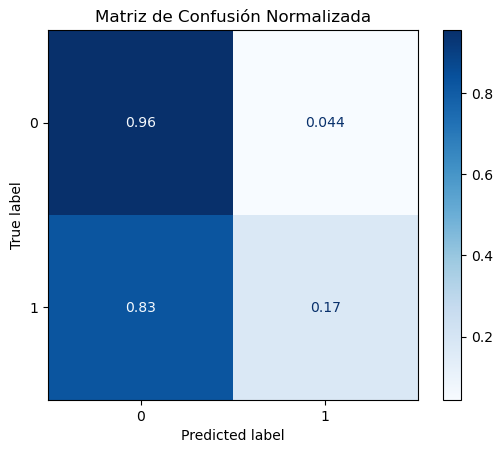


Matriz de confusi√≥n (normalizada):
[[0.95567689 0.04432311]
 [0.82526475 0.17473525]]


In [ ]:
# Configurar el Pipeline
xgb_pipeline = Pipeline(steps=[('classifier', XGBClassifier( eval_metric='logloss'))])

# Definir el espacio de hiperpar√°metros

param_grid = {
    'classifier__n_estimators': [300],
    'classifier__max_depth': [ 4, 5, 6],                 # Poca profundidad --> evitar overfitting
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1.0],           # Fracci√≥n de datos usados por cada √°rbol
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],    #  Fracci√≥n de caracter√≠sticas usadas por √°rbol
    'classifier__min_child_weight': [4, 5, 6],
    'classifier__gamma': [0.09, 0.1, 0.11],
}

# Configurar RandomizedSearchCV
CV = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # N√∫mero de combinaciones a probar
    cv=10,  # Validaci√≥n cruzada
    scoring= make_scorer(recall_score),
    random_state=seed,  # Semilla para reproducibilidad
    n_jobs=-1,  # Usar todos los n√∫cleos disponibles
    verbose=1
)

# Entrenar el modelo
CV.fit(x_resampled, y_resampled)

CV.predict(x_val)
## Almaceno los mejores par√°metros 
xgb_model = CV.best_estimator_
best_params_xgb = CV.best_params_

f.fast_eval(CV, x_val, y_val, y_pred)

In [ ]:
print(CV.estimator)

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


Text(45.722222222222214, 0.5, 'Actual')

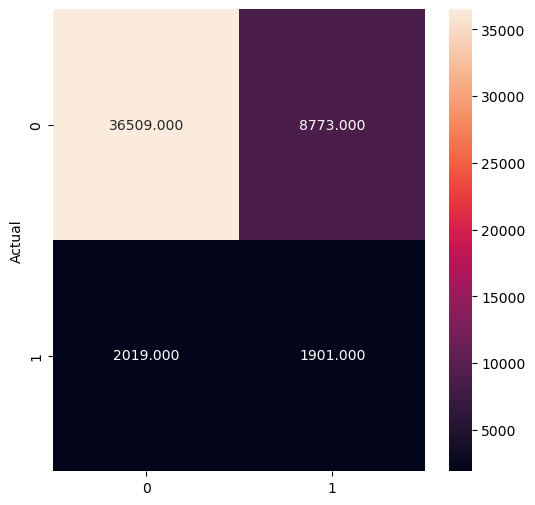

In [ ]:
prob_predictions = CV.predict_proba(X_val)

cm = confusion_matrix(y_val, y_pred)


print(CV.estimator)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.3f')
plt.ylabel('Actual')

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Confusion matrix, without normalization
[[41818  3464]
 [ 2856  1064]]
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
Normalized confusion matrix
[[0.92350161 0.07649839]
 [0.72857143 0.27142857]]


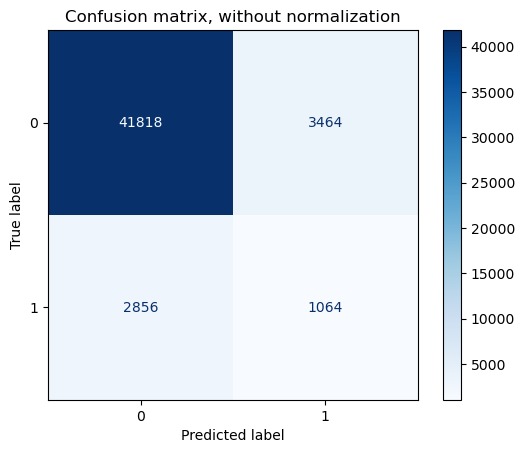

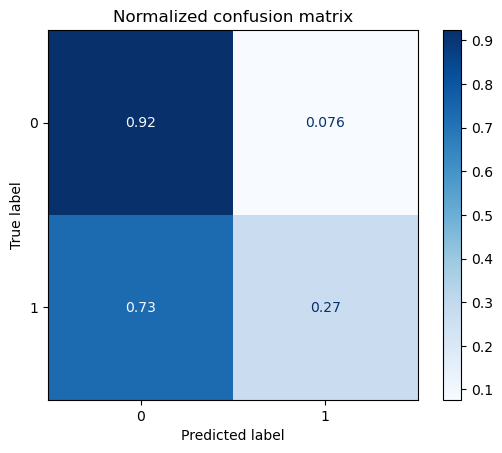

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
print(CV.estimator)
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(CV, X_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


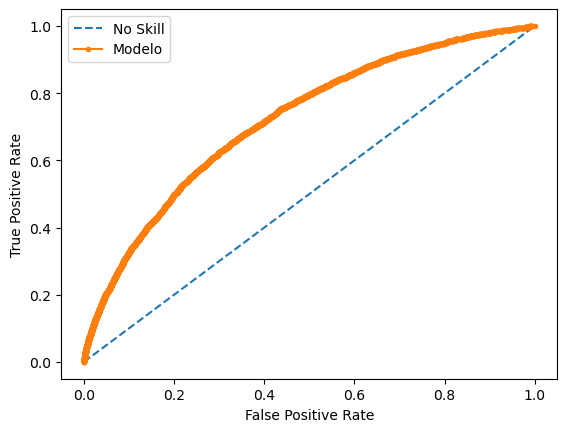

In [78]:
print(CV.estimator)

# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=f'Modelo')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [70]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
ix= np.argmax(gmeans)

print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.255536, G-Mean=0.662


Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


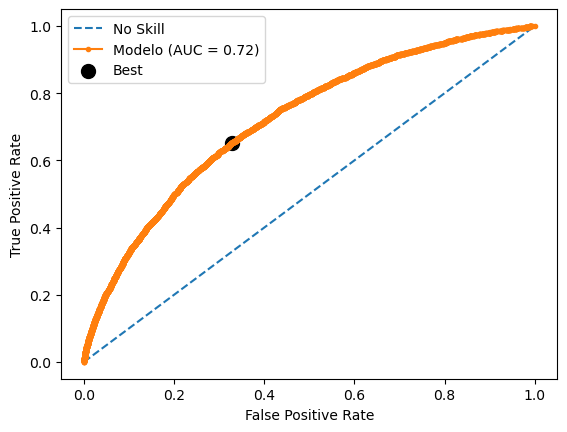

In [80]:
print(CV.estimator)

# calculate AUC
roc_auc = roc_auc_score(y_val, yhat)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')    ## Caso de aleatoriedad
plt.plot(fpr, tpr, marker='.', label=f'Modelo (AUC = {roc_auc:.2f})')   
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

# Precision Curve

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


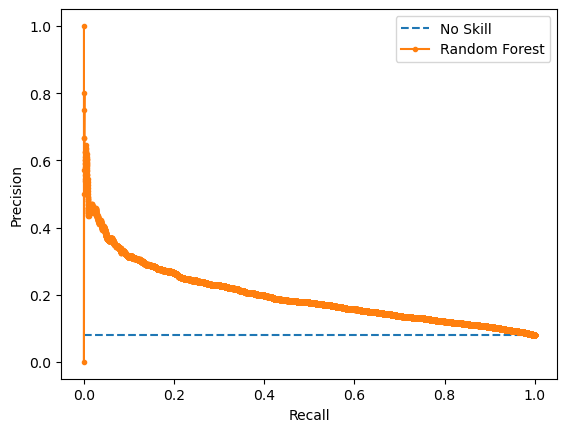

In [81]:
print(CV.estimator)

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, yhat)

# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


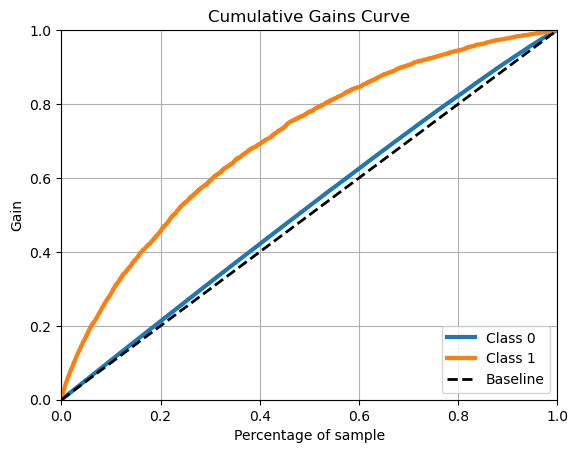

In [ ]:
print(CV.estimator)
skplt.metrics.plot_cumulative_gain(y_val, prob_predictions)
plt.show()

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced', random_state=123))])


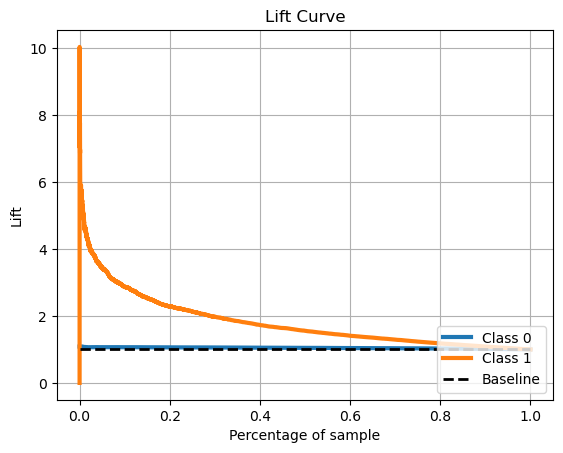

In [84]:
print(CV.estimator)
skplt.metrics.plot_lift_curve(y_val, prob_predictions)
plt.show()

# 4. - Selecci√≥n modelo final

[[0.84576653 0.15423347]
 [0.54897959 0.45102041]]


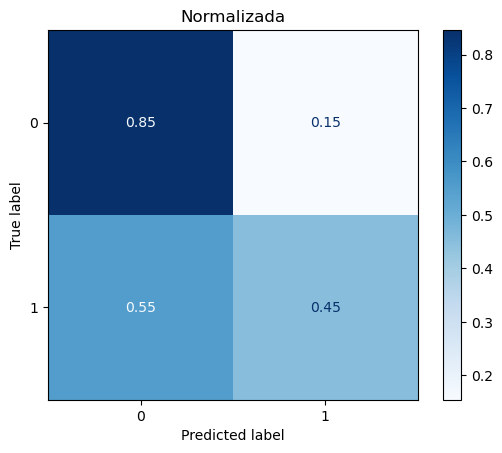

In [39]:
from sklearn.linear_model import LogisticRegression

# Crear el modelo con los par√°metros √≥ptimos
logistic_model = LogisticRegression(
    C=best_params_rl['classifier__C'],
    penalty=best_params_rl['classifier__penalty'],
    solver=best_params_rl['classifier__solver'],
    l1_ratio= best_params_rl['classifier__l1_ratio'],
    random_state=seed
)

# Entrenar el modelo con los datos
logistic_model.fit(X_resampled, y_resampled)

# Hacer predicciones con el modelo entrenado
y_pred = logistic_model.predict(X_val)

disp = ConfusionMatrixDisplay.from_estimator(logistic_model, X_val, y_val,
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title('Normalizada')

print(disp.confusion_matrix)

In [ ]:
## Guardamos el modelo ajustado para analizarlo en el siguiente notebook
from joblib import dump

# Guardar el objeto en el archivo especificado
dump(logistic_model, '../modelos/regresionlog.joblib')

['../modelos/regresionlog.joblib']